# Classification Models for Tabular Data
Purpose: To identify customers that churn with different algorithms 

Data: [Telco Churn Data](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

Metric: Recall

In [1]:
import pandas as pd
import sklearn
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt

/Users/ivanpua/opt/anaconda3/envs/ml/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv("data.csv")

# Initial Exploration

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Findings:
* CustomerID is the ID column, can be dropped for EDA
* Churn is our label
* Many features have an 'object' datatype, and its absd as it causes headache in plotting graphs on EDA, and consume a lot of compute reosurces
* TotalCharges should be numeric -- suspect there might be a string or NULL values which resulted it to be an object

In [5]:
data.drop("customerID", axis = 1, inplace=True)

# Preprocessing

## Convert Object to Numeric Type

In [6]:
df = data.copy()

In [7]:
# https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
all_features = list(df.columns)
categorical_features = [c for c in all_features if c not in numeric_features]    

for x in numeric_features:
    df[x] = pd.to_numeric(df[x],errors='coerce') 

## Scaling for Numerical Features

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

## Encoding Categorical Features
We should do this first before doing any EDA. Good software eng practice to convert every string feature to numerical. Easy now because its only 1MB, but imagein 10GB of object type data

In [9]:
def unique_counts(df, columns):
    '''Prints the unique values in a column'''
    
    for col in columns:
        values = sorted(df[col].unique())
        
        if len(values) != 2:
            
            print(f"ALERT: {col} has {len(values)} unique values")
            print(values)
        
        else:
            if values[0] != 'No' and values[0] != 'Yes':
                print(f"ALERT:{col} has 2 unique values which are not 'Yes' or 'No'.")
                print(values) 
            else:
                print(f"{col} has exactly 2 unique values of 'Yes' and 'No'.")
                
    

Some columns are either 'Yes' or 'No', some have additional class called 'No phone/internet service'. To be catious, 'No' and 'no phone/internet service' are different -- consult SME

In [10]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()

In [11]:
unique_counts(df, categorical_cols)

ALERT:gender has 2 unique values which are not 'Yes' or 'No'.
['Female', 'Male']
Partner has exactly 2 unique values of 'Yes' and 'No'.
Dependents has exactly 2 unique values of 'Yes' and 'No'.
PhoneService has exactly 2 unique values of 'Yes' and 'No'.
ALERT: MultipleLines has 3 unique values
['No', 'No phone service', 'Yes']
ALERT: InternetService has 3 unique values
['DSL', 'Fiber optic', 'No']
ALERT: OnlineSecurity has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: OnlineBackup has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: DeviceProtection has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: TechSupport has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: StreamingTV has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: StreamingMovies has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: Contract has 3 unique values
['Month-to-month', 'One year', 'Two year']
PaperlessBilling has exactly 2 unique values of 'Ye

None of the features have ordinality (e.g. a natural order like cold, warm, hot). We can still use OrdinalEncoder() with arbritary numbers

In [12]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(dtype = 'int64')

# apply Ordinal Encoder on categorical feature columns
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

In [13]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.277445,0,1,0,0,2,0,0,0,0,0,1,2,-1.160323,-0.994194,0
1,1,0,0,0,0.066327,1,0,0,2,0,2,0,0,0,1,0,3,-0.259629,-0.173740,0
2,1,0,0,0,-1.236724,1,0,0,2,2,0,0,0,0,0,1,3,-0.362660,-0.959649,1
3,1,0,0,0,0.514251,0,1,0,2,0,2,2,0,0,1,0,0,-0.746535,-0.195248,0
4,0,0,0,0,-1.236724,1,0,1,0,0,0,0,0,0,0,1,2,0.197365,-0.940457,1


In [14]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   float64
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


In [15]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7032.00,7043.00
mean,0.50,0.16,0.48,0.30,0.00,0.90,0.94,0.87,0.79,0.91,0.90,0.80,0.99,0.99,0.69,0.59,1.57,-0.00,0.00,0.27
std,0.50,0.37,0.50,0.46,1.00,0.30,0.95,0.74,0.86,0.88,0.88,0.86,0.89,0.89,0.83,0.49,1.07,1.00,1.00,0.44
min,0.00,0.00,0.00,0.00,-1.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.55,-1.00,0.00
25%,0.00,0.00,0.00,0.00,-0.95,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,-0.97,-0.83,0.00
50%,1.00,0.00,0.00,0.00,-0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,2.00,0.19,-0.39,0.00
75%,1.00,0.00,1.00,1.00,0.92,1.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.00,0.83,0.67,1.00
max,1.00,1.00,1.00,1.00,1.61,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,3.00,1.79,2.82,1.00


# Missing Values in Data

In [16]:
def missing_values_table(df):
    
    '''This function calculates the percentage of missing values per column in the given dataframe'''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print (f"Your selected dataframe has {str(df.shape[1])} columns.")     
    print(f"There are {str(mis_val_table_ren_columns.shape[0])} columns that have missing values.")
    
    return mis_val_table_ren_columns

In [17]:
missing_values_table(df)

Your selected dataframe has 20 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
TotalCharges,11,0.2


<AxesSubplot:>

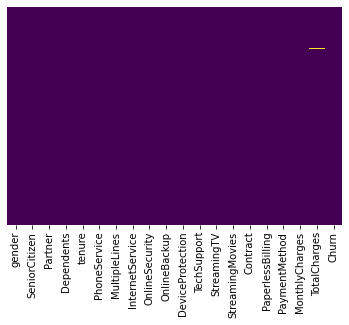

In [18]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In [19]:
# Check rows with missing data
df.loc[df['TotalCharges'].isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,0,0,1,1,-1.318165,0,1,0,2,0,2,2,2,0,2,1,0,-0.405867,NaN,0
753,1,0,0,1,-1.318165,1,0,2,1,1,1,1,1,1,2,0,3,-1.479388,NaN,0
936,0,0,1,1,-1.318165,1,0,0,2,2,2,0,2,2,2,0,3,0.534710,NaN,0
1082,1,0,1,1,-1.318165,1,2,2,1,1,1,1,1,1,2,0,3,-1.296590,NaN,0
1340,0,0,1,1,-1.318165,0,1,0,2,2,2,2,2,0,2,0,1,-0.289541,NaN,0
3331,1,0,1,1,-1.318165,1,0,2,1,1,1,1,1,1,2,0,3,-1.492682,NaN,0
3826,1,0,1,1,-1.318165,1,2,2,1,1,1,1,1,1,2,0,3,-1.309885,NaN,0
4380,0,0,1,1,-1.318165,1,0,2,1,1,1,1,1,1,2,0,3,-1.487697,NaN,0
5218,1,0,1,1,-1.318165,1,0,2,1,1,1,1,1,1,1,1,3,-1.497668,NaN,0
6670,0,0,1,1,-1.318165,1,2,0,0,2,2,2,2,0,2,0,3,0.285440,NaN,0


In [20]:
# After checking, there are few rows with missing data, can be omitted instead of imputed 
df.dropna(inplace=True)

In [21]:
y = df.pop('Churn')
X = df

In [22]:
df.to_csv('preprocessed.csv')

## Train Test Split

In [23]:
# to read 
df = pd.read_csv('preprocessed.csv')

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Model Training
---

# Linear Model

## Logistic Regression

In [25]:
%%time

from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=5, 
                             random_state=0
                            )
model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7967

CPU times: user 2.51 s, sys: 738 ms, total: 3.24 s
Wall time: 711 ms


## Elastic Net

In [26]:
%%time

from sklearn.linear_model import ElasticNetCV

model = ElasticNetCV(cv=5, 
                     random_state=0
                    )
model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.269

CPU times: user 254 ms, sys: 94.5 ms, total: 348 ms
Wall time: 79.5 ms


## Support Vector Machine (SVM)

In [27]:
%%time

from sklearn.svm import SVC

model = SVC(random_state=0)
model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7953

CPU times: user 1.86 s, sys: 233 ms, total: 2.09 s
Wall time: 1.43 s


## KNN Classifier

In [28]:
%%time

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=50)
model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7818

CPU times: user 341 ms, sys: 81.3 ms, total: 422 ms
Wall time: 86.5 ms


## Naive Bayes

In [29]:
%%time

from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7534

CPU times: user 16.5 ms, sys: 8.45 ms, total: 25 ms
Wall time: 5 ms


# Decision Tree

In [30]:
%%time

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7193

CPU times: user 99.3 ms, sys: 44 ms, total: 143 ms
Wall time: 30.9 ms


# Ensemble Methods
1. Random Forest
2. AdaBoost
3. Gradient Booster 
4. Majority Voting Classifier

In [31]:
%%time

# Random Forest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7918

CPU times: user 720 ms, sys: 165 ms, total: 886 ms
Wall time: 433 ms


In [32]:
%%time

# Adaboost
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7974

CPU times: user 335 ms, sys: 4.93 ms, total: 340 ms
Wall time: 339 ms


In [33]:
%%time

# GBT
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100, 
                                   learning_rate=1.0,
                                   max_depth=10, 
                                   random_state=0)
model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7612

CPU times: user 2.07 s, sys: 14.9 ms, total: 2.09 s
Wall time: 2.09 s


In [34]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Majority Voting Classifier

model_1 = LogisticRegression(random_state=1)
model_2 = RandomForestClassifier(n_estimators=100, random_state=1)
model_3 = GaussianNB()

ensemble_model = VotingClassifier(estimators=[('lr', model_1), ('rf', model_2), ('gnb', model_3)],
                                  voting='hard'
                                 )

model = ensemble_model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7989

CPU times: user 1.11 s, sys: 302 ms, total: 1.41 s
Wall time: 471 ms


In [35]:
%%time

# Weighted Classifier

model_1 = LogisticRegression(random_state=1)
model_2 = RandomForestClassifier(n_estimators=100, random_state=1)
model_3 = GaussianNB()

ensemble_model = VotingClassifier(estimators=[('lr', model_1), ('rf', model_2), ('gnb', model_3)],
                                  voting='soft', weights=[2, 1, 2]
                                 )

model = ensemble_model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")

Accuracy (recall) is 0.7761

CPU times: user 1.02 s, sys: 295 ms, total: 1.32 s
Wall time: 470 ms


## Neural Networks

In [36]:
%%time

# GBT
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='adam', 
                      activation = 'relu',
                      learning_rate_init = 0.001,
                      alpha=1e-5,
                      hidden_layer_sizes=(15,), 
                      max_iter = 400,
                      random_state=1
                     )

model.fit(X_train, y_train)

recall = model.score(X_test, y_test)
print(f"Accuracy (recall) is {round(recall, 4)}\n")



Accuracy (recall) is 0.7967

CPU times: user 10.6 s, sys: 3.14 s, total: 13.7 s
Wall time: 2.57 s


# Model Selection

In [44]:
# For ensemble model
model_1 = LogisticRegression(random_state=0)
model_2 = RandomForestClassifier(n_estimators=100, random_state=0)
model_3 = GaussianNB()

models =[
    LogisticRegressionCV(cv=5, random_state=0),
    ElasticNetCV(cv=5, random_state=0),
    SVC(random_state=0),
    KNeighborsClassifier(n_neighbors=50),
    GaussianNB(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    GradientBoostingClassifier(n_estimators=100, 
                                   learning_rate=1.0,
                                   max_depth=10, 
                                   random_state=0),
    VotingClassifier(estimators=[('lr', model_1), ('rf', model_2), ('gnb', model_3)],
                                  voting='hard'
                                 ),
    VotingClassifier(estimators=[('lr', model_1), ('rf', model_2), ('gnb', model_3)],
                                  voting='soft', weights=[2, 1, 2]
                                 ),
    MLPClassifier(solver='adam', 
                      activation = 'relu',
                      learning_rate_init = 0.001,
                      alpha=1e-5,
                      hidden_layer_sizes=(15,), 
                      max_iter = 400,
                      random_state=1
                     )
]

scores={}

for model in models:
    
    model_name = model.__class__.__name__
    
    model.fit(X_train, y_train)
    recall = model.score(X_test, y_test)
    
    recall = round(recall, 4)
    
    scores[model_name] = recall
    
    print(f"Accuracy (recall) of {model.__class__.__name__} is {round(recall, 4)}")
    
best_score = max(scores.values())
best_model = max(scores, key=scores.get)

print(f"Best score is {best_score} by {best_model}")

Accuracy (recall) of LogisticRegressionCV is 0.7967
Accuracy (recall) of ElasticNetCV is 0.269
Accuracy (recall) of SVC is 0.7953
Accuracy (recall) of KNeighborsClassifier is 0.7818
Accuracy (recall) of GaussianNB is 0.7534
Accuracy (recall) of DecisionTreeClassifier is 0.7193
Accuracy (recall) of RandomForestClassifier is 0.7918
Accuracy (recall) of AdaBoostClassifier is 0.7974
Accuracy (recall) of GradientBoostingClassifier is 0.7612
Accuracy (recall) of VotingClassifier is 0.7989
Accuracy (recall) of VotingClassifier is 0.774
Accuracy (recall) of MLPClassifier is 0.7967
Best score is 0.7974 by AdaBoostClassifier
